# RS evaluation with a custom response model

This tutorial shows how to use Sim4Rec for the following purposes:
- Generate synthetic data based on real data; 
- Create a custom response function;
- Measure quality with a custom metric;
- Create a simple simulation pipeline for long-term performance evaluation of a recommender system.

### Users & Items
We create 10000 users and 200 items, then generate 5000 synthetic users and 100 synthetic items by random sampling.

### Recommender Model
We use Upper Confidence Bound (UCB) algorithm as the recommender.

### Response Function
We use a simple response function to sample responses to recommended items. The probability of a response is fixed and and is equal to one tenth of the last digit of an item id. So there are more popular items with a higher probability of a response.

### Quality Metric
We measure the quality of recommendations as the average number of positive responses per user.

### Simulation Cycle
We evaluate the long-term performance of the recommender system in the simulation cycle by sampling responses to recommended items, retraining the recommender model, and evaluating it in each iteration of the cycle. 

## Imports and preparations

In [1]:
import os
import sys
os.environ["JAVA_HOME"] = "/home/jovyan/ivanova/env39_sim4rec_demo_new"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["OMP_NUM_THREADS"] = "32"
os.environ["NUMBA_NUM_THREADS"] = "4"

In [2]:
import random
import time

import numpy as np
import pandas as pd
import warnings

from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf

from experiments.response_models.utils import plot_metric, calc_metric
from sim4rec.modules import RealDataGenerator
from sim4rec.modules import Simulator
from sim4rec.recommenders.ucb import UCB
from sim4rec.response import BernoulliResponse,  ActionModelTransformer

warnings.filterwarnings("ignore") 

In [3]:
# path to spark tmp folder and simulator checkpoints
SPARK_LOCAL_DIR = './tmp/task_1'
CHECKPOINT_DIR = './tmp/task_1_checkpoints'

In [4]:
%%bash -s "$CHECKPOINT_DIR" "$SPARK_LOCAL_DIR"
# Simulator keeps history of interactions between users and recommender system
# To re-run the simulation cycle or start a new one, clear the directory or use a different CHECKPOINT_DIR
rm -rf $1 $2

In [5]:
NUM_THREADS = 4

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_THREADS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_THREADS * 3}')\
    .config('spark.default.parallelism', f'{NUM_THREADS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')

24/10/04 11:40:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/04 11:40:18 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/10/04 11:40:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
NUM_USERS = 5000 # number of generated users 
NUM_ITEMS = 100 # number of generated items
K = 5 # number of predicted items
NUM_ITER = 50 # number of iterations
SEED = 1234
np.random.seed(SEED)

## Data generation

We create 10000 users and 200 items, fit RealDataGenerator to them and then generate 5000 users and 100 items by random sampling. Users and items generation for industrial size data can be done in a similar way.

In [7]:
users = spark.createDataFrame([[x] for x in range(NUM_USERS * 2)], schema=["user_idx"])
items = spark.createDataFrame([[x] for x in range(NUM_ITEMS * 2)], schema=["item_idx"])
items.count()

200

In [8]:
items.limit(2).toPandas()

,item_idx
0,0
1,1


In [9]:
item_generator = RealDataGenerator(label='items_real', seed=SEED)
user_generator = RealDataGenerator(label='users_real', seed=SEED)

item_generator.fit(items)
user_generator.fit(users)

item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)
item_generator.getDataSize()

100

# One iteration of simulation cycle step by step

## (1) Choise of users

Sample 0.1 of generated users.

In [10]:
user_generator.sample(0.1).count()

504

## (2) Choise of items
During the simulation cycle, all 100 items are available at each iteration.

## (3) Recommender model

UCB model should be fitted to historical data before it can be refitted in cycle. Let's assume we had one interaction for simplicity.

In [11]:
# initialization of recommender model
rs_model = UCB(sample=True, seed=SEED)
# fit recommender model
rs_model.fit(
    log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1))
)
# get top k items for each user 
pred = rs_model.predict(log=None, users=users.limit(2), items=items, k=2)
pred.limit(5).toPandas()

,user_idx,item_idx,relevance
0,0,195,0.005
1,0,76,0.005
2,1,35,0.005
3,1,36,0.005


## (4) Response Function

The response function in this tutorial is constant over time and very simple. The response is binary, response == 1 means the user bought the item.  

The probability of a response is fixed and is equal to one tenth of the last digit of an `item_idx`. So there are more popular items with higher probability of a response and a simple recommender model should be able to identify them.

The response function takes a dataframe with the columns `user_idx`, `item_idx`, `relevance` and returns a dataframe with the columns `user_idx`, `item_idx`, `relevance`, `response_proba`, `response`, adding the response column to the original columns. If the initial dataframe had other columns, they are returned as well.

In [12]:
# An example of calculating the probability of a response for the response model.
items.limit(5).withColumn(
    "response_proba", (sf.col("item_idx") % sf.lit(10)) / sf.lit(10)
).toPandas()

,item_idx,response_proba
0,0,0.0
1,1,0.1
2,2,0.2
3,3,0.3
4,4,0.4


In [13]:
class PopBasedTransformer(ActionModelTransformer):
    def __init__(
        self,
        inputCol: str = None,
        outputCol: str = None,
    ):
        """
        Class for the response function. 
        The probability of a response is fixed and 
        is equal to one tenth of the last digit of an item id from inputCol. 
        :param inputCol: Name of the item id column
        :param outputCol: Name of the response probability column
        :returns: dataframe with outputCol
        """
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataframe):
        return dataframe.withColumn(
            self.outputCol, (sf.col(self.inputCol) % sf.lit(10)) / sf.lit(10)
        )

To construct the response function pipeline, we need to initialize PopBasedTransformer to get the response probability for each item and BernoulliResponse to model the non-deterministic behavior of the user.

In [14]:
# initialization of response function
popularity_model = PopBasedTransformer(inputCol="item_idx", outputCol="response_proba")
# initialization of Bernoulli response sampling
br = BernoulliResponse(inputCol="response_proba", outputCol="response", seed=SEED)
# get response pipeline
response_pipeline = Pipeline(stages=[popularity_model, br])
# fit response pipeline
response_model = response_pipeline.fit(items)
# get users' responses on recommended items
test_response = response_model.transform(pred)
test_response.limit(5).toPandas()

,user_idx,item_idx,relevance,response_proba,response
0,0,195,0.005,0.5,0
1,0,76,0.005,0.6,0
2,1,35,0.005,0.5,0
3,1,36,0.005,0.6,1


## (5) Fitting of recommender model on new data

After receiving responses to recommendations, we can use this information to update the recommender model. To do this, we should rename column `response` to `relevance`.

In [15]:
new_log = test_response.drop("relevance", "response_proba").withColumnRenamed(
    "response", "relevance"
)
new_log.limit(5).toPandas()

,user_idx,item_idx,relevance
0,0,195,0
1,0,76,0
2,1,35,0
3,1,36,1


In [16]:
rs_model.fit(log=new_log)
rs_model.item_popularity.limit(5).toPandas()

,item_idx,relevance
0,195,1.442027
1,76,1.442027
2,35,1.442027
3,36,2.442027


## (6) Quality of recommendations

Quality is the average number of positive responses on recommended items per user.

In [18]:
calc_metric(test_response)

0.5

# Training the model in the simulator

In [19]:
%%bash -s "$CHECKPOINT_DIR"
rm -rf $1

## Simulator initialization

In [20]:
user_generator.initSeedSequence(SEED)
item_generator.initSeedSequence(SEED)

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark
)

Check that the format is correct.

In [21]:
pred = rs_model.predict(log=None, users=users.limit(10), items=items, k=K)

assert pred.columns == ["user_idx", "item_idx", "relevance"]
assert (
    pred.groupBy("user_idx")
    .agg(sf.countDistinct("item_idx").alias("num_items"))
    .filter(sf.col("num_items") == sf.lit(K))
    .count()
    == 10
)
assert (
    pred.groupBy("user_idx")
    .agg(sf.count("item_idx").alias("num_items"))
    .filter(sf.col("num_items") == sf.lit(K))
    .count()
    == 10
)

## Response function initialization

In [22]:
response_model = response_pipeline.fit(items)

## Simulation cycle

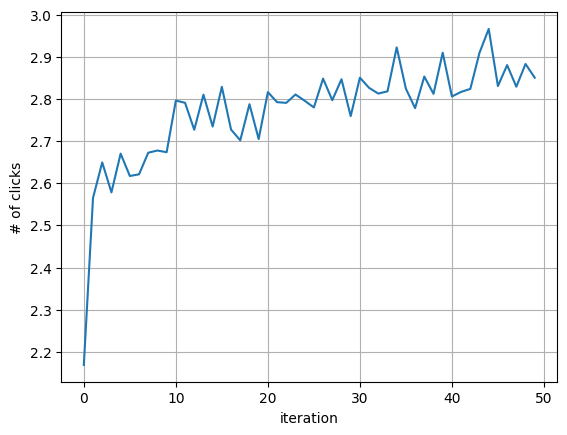

Iteration 49 finished in 8.062345743179321 sec.


In [23]:
metrics = []
for i in range(NUM_ITER):
    print(f"Iteration {i} started")
    iter_time = time.time()
    # sample users
    current_users = sim.sample_users(0.1).repartition(NUM_THREADS * 3).cache()
    # history of interactions
    log = sim.get_log(current_users)
    # getting recommendations for sampled users from the recommender system
    recs = rs_model.predict(
        log=log, k=5, users=current_users, items=items, filter_seen_items=False
    )
    # getting responses to recommended items from the response function
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=response_model,
    )
    # update user interaction history
    sim.update_log(true_resp, iteration=i)
    # measure the quality of the recommender system
    metrics.append(calc_metric(true_resp))
    # refitting the recommender model
    rs_model._clear_cache()
    train_log = sim.log
    rs_model.fit(
        log=train_log.select("user_idx", "item_idx", "response").withColumnRenamed(
            "response", "relevance"
        )
    )

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    plot_metric(metrics)
    print(f"Iteration {i} finished in {time.time() - iter_time} sec.")

In [24]:
sim.log.filter(sf.col("__iter") == 1).show(2)

+--------+--------+--------------------+--------------+--------+------+
|item_idx|user_idx|           relevance|response_proba|response|__iter|
+--------+--------+--------------------+--------------+--------+------+
|      27|      52|0.006269646504010278|           0.7|       1|     1|
|      14|      52|0.005111431081246217|           0.4|       0|     1|
+--------+--------+--------------------+--------------+--------+------+
only showing top 2 rows



The quality of the recommender model has improved during the training cycle.

# Final prediction

After training the recommender system in the simulation cycle we get recommendations for all users from the recommender system.

In [25]:
recs = rs_model.predict(
    log=sim.log, k=K, users=users, items=items, filter_seen_items=False
).cache()

Then we get responses and measure the quality of the recommender system.

In [26]:
# responses from the response model
true_resp = sim.sample_responses(
    recs_df=recs, user_features=users, item_features=items, action_models=response_model
).cache()

# model quality
print(
    f"Average number of clicks per user after model training = {calc_metric(true_resp)}"
)

Average number of clicks per user after model training = 2.8672


In [27]:
recs.unpersist()
true_resp.unpersist()

DataFrame[item_idx: int, user_idx: int, relevance: double, response_proba: double, response: int]

Find the most popular items with the highest relevance. The most popular items have ids ending in 9 because they have the highest probability of response.

In [28]:
# the most popular items 
rs_model.item_popularity.orderBy(sf.col('relevance').desc()).show()

+--------+------------------+
|item_idx|         relevance|
+--------+------------------+
|      99|1.0261915537353732|
|      49|1.0226645595481847|
|      69|1.0221211912145758|
|       9|1.0211361945284638|
|     139|1.0193347366527326|
|      89|1.0182569601908482|
|     159| 1.018043579433346|
|     189|1.0175983133091875|
|      79|1.0156099705283423|
|     199|1.0152934300946403|
|     149| 1.013438139409007|
|      29| 1.013418091839723|
|      59|1.0127609676793394|
|      39|1.0093342406581383|
|     119|1.0085701161067904|
|      19|1.0071971582561654|
|     109|1.0062501885591957|
|     179|0.9995607149707373|
|     169|0.9985615659476608|
|     129|0.9975857811937804|
+--------+------------------+
only showing top 20 rows

